# Evaluation for Kirk Experiment

In [33]:
import sys
from omegaconf import OmegaConf, DictConfig
from typing import Union, Dict, Optional

sys.path.append("../..")
folder_train = '/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-07-01/14-14-50_benchmark_train/'
folder_eval = '/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-07-06/17-21-44'

def recover_traincfg_from_wandb(fn_wbcfg: str, to_dict: bool = False) -> Optional[Union[DictConfig, Dict]]:
    wbcfg = OmegaConf.load(fn_wbcfg)
    if not "traincfg" in wbcfg:
        return None
    traincfg = wbcfg.traincfg
    traincfg = OmegaConf.to_container(cfg=traincfg, resolve=False, enum_to_str=True)["value"]
    traincfg = ast.literal_eval(traincfg)
    traincfg = OmegaConf.create(traincfg)
    if to_dict:
        traincfg = OmegaConf.to_container(cfg=traincfg, resolve=True, enum_to_str=True)
    return traincfg

In [46]:
from rich import print as printr
from rich.progress import track
from pathlib import Path
import ast
import pandas as pd
from tqdm import tqdm
from wandb.sdk.wandb_helper import parse_config
from experiments.common.utils.json_utils import lazy_json_load
from experiments.evaluation.run_evaluation import find_multirun_paths

fn_config = ".hydra/config.yaml"
fn_wbsummary = "wandb/latest-run/files/wandb-summary.json"
fn_wbconfig = "wandb/latest-run/files/config.yaml"

paths = find_multirun_paths(result_dir=folder_eval)

entries = []
for p in tqdm(paths):
    p = Path(p)
    fn_cfg = p / fn_config
    fn_wbsum = p / fn_wbsummary
    fn_wbcfg = p / fn_wbconfig
    if not fn_wbcfg.is_file() or not fn_wbsum.is_file() or not fn_cfg.is_file():
        continue
    cfg = OmegaConf.load(fn_cfg)
    traincfg = recover_traincfg_from_wandb(fn_wbcfg)
    summary = lazy_json_load(fn_wbsum)

    if traincfg is not None:
        mode = traincfg.kirk_evaluation_protocol.mode
    else:
        mode = cfg.kirk_evaluation_protocol.mode
    if "average_return" in summary:
        average_return = summary["average_return"]
    else:
        average_return = None

    if mode is None or average_return is None:
        continue

    entry = {
        "mode": mode,
        "distribution_type": cfg.kirk_evaluation_protocol.distribution_type,
        "average_return": average_return,
    }
    entries.append(entry)

df = pd.DataFrame(entries)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [00:04<00:00, 71.96it/s]

    mode                 distribution_type  average_return
0      A                             train      478.121667
1      A                             train      494.834000
2      A                             train      440.882000
3      B                             train      497.043667
4      B                             train      487.128000
..   ...                               ...             ...
155    C  test_interpolation_combinatorial      474.966333
156    C  test_interpolation_combinatorial      499.717667
157    B  test_interpolation_combinatorial      492.186333
158    B  test_interpolation_combinatorial      499.995333
159    B  test_interpolation_combinatorial      500.000000

[160 rows x 3 columns]


/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


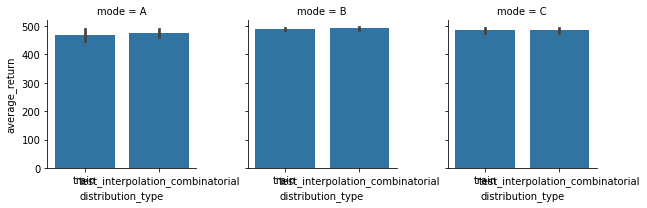

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

grid = sns.FacetGrid(df, col="mode")
grid.map(sns.barplot, "distribution_type", "average_return")